## Notebook to create raster masks from polygons
Needed for semantic segmentation of raster images. 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
sys.path.append('scripts/')
import numpy as np
import matplotlib.pyplot as plt
import rasterio, rasterio.plot
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
import land_cover_models as lcm
from torch.utils.data import TensorDataset, DataLoader

path_dict = loadpaths.loadpaths()

### Example:
- Load tiff tile as example image
- Get the class polygons
- Find intersections of polygons and image tile
- Create raster mask

(3, 8000, 8000) <class 'numpy.ndarray'>


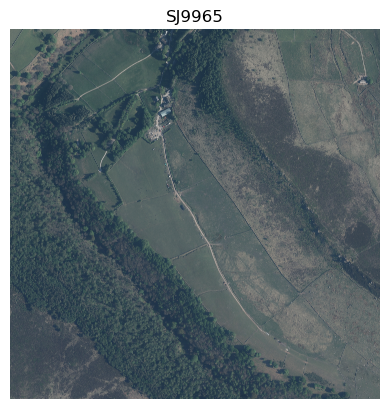

In [14]:
## Load image:

example_tiff_file = 'SJ9965.tif'
example_tiff_path = os.path.join(path_dict['image_path'], example_tiff_file)

ex_tile = lca.load_tiff(tiff_file_path=example_tiff_path, datatype='da')
lcv.plot_image_simple(im=ex_tile, name_file=example_tiff_file)

(3, 8450, 8450) <class 'numpy.ndarray'>


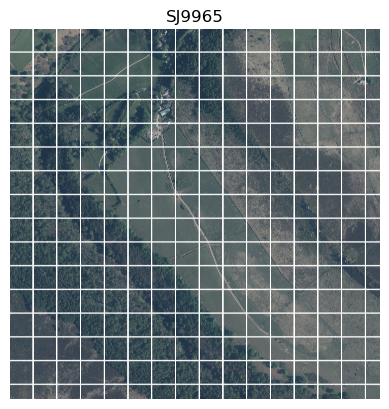

In [20]:
tmp = lcv.plot_image_as_patches(im=ex_tile, name_file=example_tiff_file)

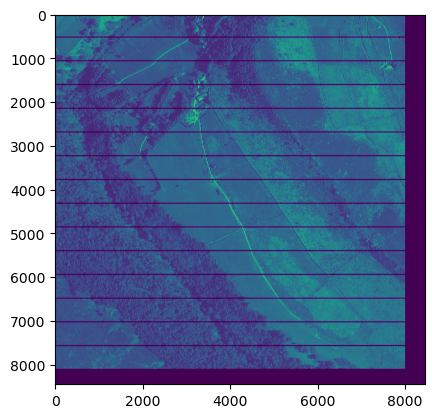

In [12]:
plt.imshow(tmp[0, :, :])

In [3]:
## Load landcover polygons:

df_lc_80s, mapping_class_inds = lca.load_landcover(pol_path=os.path.join(path_dict['lc_80s_path']))
df_lc_80s

,AREA,PERIMETER,LC_N_80,LC_D_80,MI_PRINX,geometry
0,2.288935e+05,1931.281171,19,Improved Pasture,1,"POLYGON ((407724.666 411168.713, 407854.641 41..."
1,8.103939e+05,6180.868624,12,Upland Heath/Grass Mosaic,2,"POLYGON ((407267.642 410992.244, 407326.372 41..."
2,3.024182e+06,30493.715242,7,Upland Grass Moor,3,"POLYGON ((405616.816 409724.857, 405615.571 40..."
3,3.141201e+06,17829.297205,8,Blanket Peat Grass Moor,4,"POLYGON ((406402.661 410926.453, 406419.695 41..."
4,5.524007e+03,360.239964,20,Rough Pasture,5,"POLYGON ((405569.382 410874.398, 405584.644 41..."
...,...,...,...,...,...,...
8477,2.946860e+03,210.674150,19,Improved Pasture,8478,"POLYGON ((416356.527 348866.777, 416357.591 34..."
8478,1.588031e+03,186.955561,1,Broadleaved High Forest,8479,"POLYGON ((412660.720 348649.559, 412658.280 34..."
8479,6.253066e+03,340.410463,36,Isolated Farmsteads (>0.25 ha),8480,"POLYGON ((412871.439 348609.371, 412858.033 34..."
8480,1.770921e+05,2285.262979,2,Coniferous High Forest,8481,"POLYGON ((411786.076 405491.149, 411803.349 40..."


In [37]:
df_tiles_few_changes = lca.load_pols('content/tiles_few_changes/tiles_few_changes.shp')
dict_intersect_pols_tiles_few_changes = lca.get_pols_for_tiles(df_pols=df_lc_80s, df_tiles=df_tiles_few_changes, col_name='PLAN_NO')
df_tiles_few_changes_lc = pd.concat(list(dict_intersect_pols_tiles_few_changes.values())).reset_index(drop=True)


100%|██████████| 40/40 [00:02<00:00, 16.02it/s]


Text(0.5, 1.0, 'Distribution of LC of entire PD')

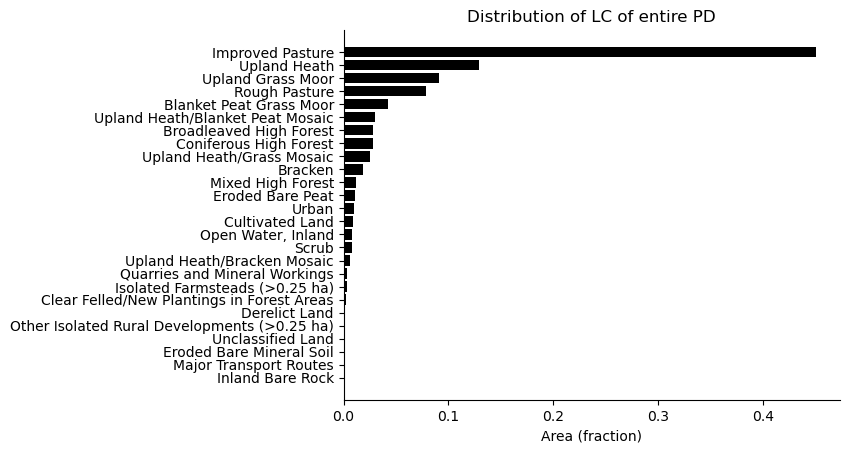

In [27]:
ax_distr, _ = lcv.plot_distr_classes_from_shape(df_lc=df_lc_80s)
ax_distr.set_title('Distribution of LC of entire PD')

Text(0.5, 1.0, 'Distribution of LC of tiles-few-changes data set')

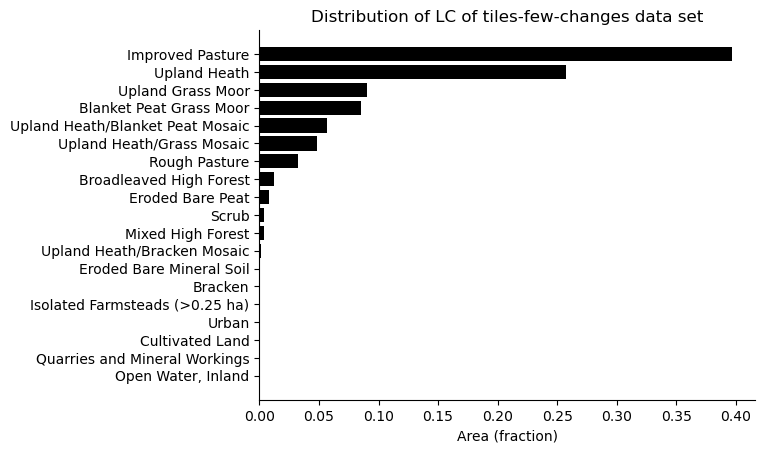

In [38]:
ax_distr, _ = lcv.plot_distr_classes_from_shape(df_lc=df_tiles_few_changes_lc)
ax_distr.set_title('Distribution of LC of tiles-few-changes data set')

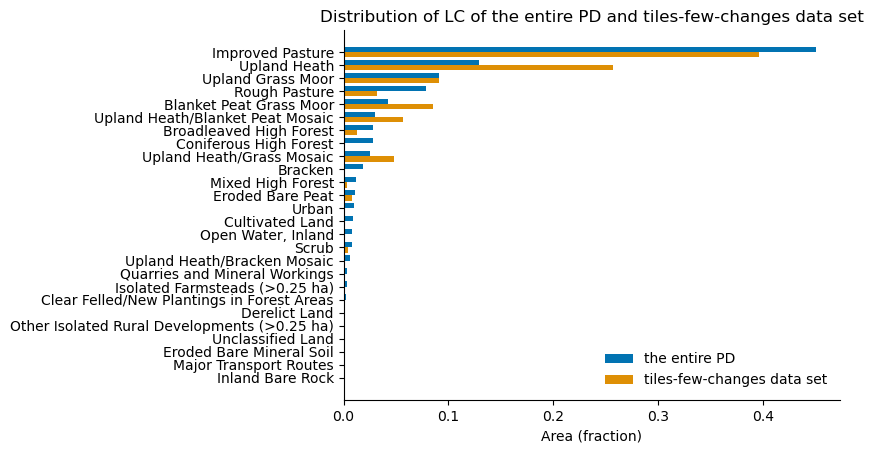

In [54]:
ax_distr, _ = lcv.plot_distr_classes_from_multiple_shapes(dict_dfs_lc={'the entire PD': df_lc_80s, 'tiles-few-changes data set': df_tiles_few_changes_lc})

In [4]:
## Get intersection of polygons with tiles
# df_tiles = lca.create_df_with_tiff_coords(tiff_paths=lca.get_all_tifs_from_dir(path_dict['image_path']), verbose=1)  # get df of square polygons of tiles 
df_tiles = lca.create_df_with_tiff_coords(tiff_paths=lca.get_all_tifs_from_subdirs('/home/tplas/data/gis/most recent APGB 12.5cm aerial/tiles_few_changes/117523_20221107/12.5cm Aerial Photo/'), verbose=1)  # get df of square polygons of tiles 
# df_tiles = lca.create_df_with_tiff_coords(tiff_paths=lca.get_all_tifs_from_dir(path_dict['image_path']), verbose=1)  # get df of square polygons of tiles 
dict_intersect_pols = lca.get_pols_for_tiles(df_pols=df_lc_80s, df_tiles=df_tiles)

Loading 40 tiff files


100%|██████████| 40/40 [00:02<00:00, 16.13it/s]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


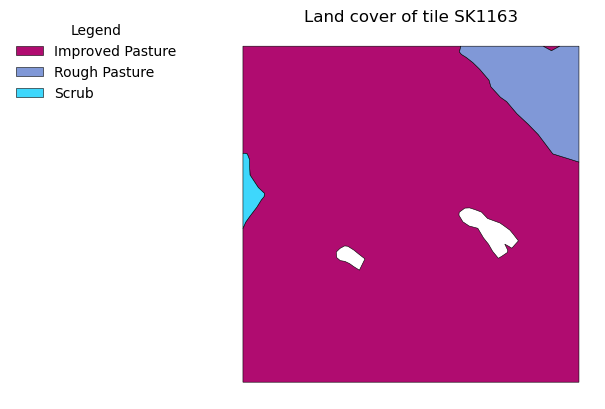

In [5]:
_ = lcv.plot_lc_from_gdf_dict(df_pols_tiles=dict_intersect_pols, tile_name="SK1163")

Current data size cube is 512.128008 MB
New cube data size is 64.128008 MB


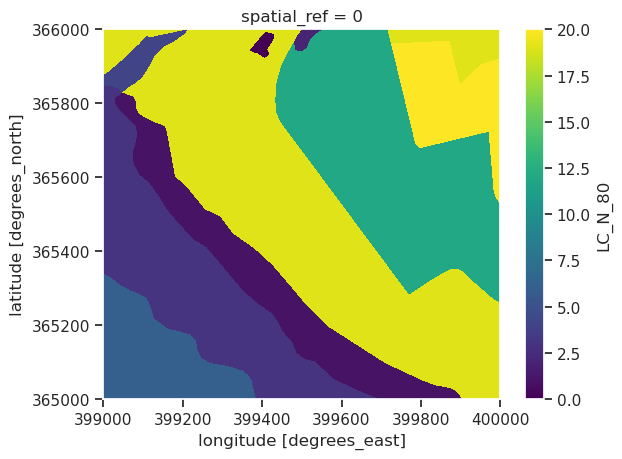

In [137]:
## Example: convert polygons labels to raster:
dict_shp = dict_intersect_pols
key_tile = "SJ9965"

ex_raster = lca.convert_shp_mask_to_raster(df_shp=dict_shp[key_tile], filename=key_tile + '_lc_80s_mask', 
                                plot_raster=True, # whether to plot
                                save_raster=False, # whether to store on disk
                                verbose=1)

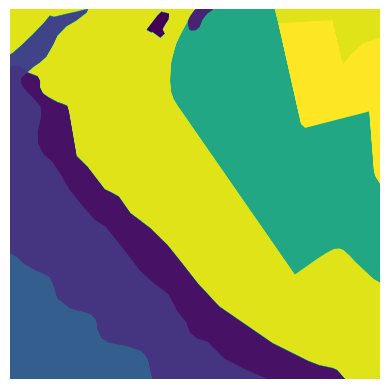

In [11]:
## Load saved raster mask
ex_mask_tif = lca.load_tiff(tiff_file_path=os.path.join(path_dict['mask_path'], 'SJ9965' + '_lc_80s_mask.tif'))
lcv.plot_image_simple(im=ex_mask_tif)

In [6]:
## Convert all polygons labels to raster:
dict_shp = dict_intersect_pols

for key_tile, df_tile in tqdm(dict_shp.items()):

    ex_raster = lca.convert_shp_mask_to_raster(df_shp=df_tile, filename=key_tile + '_lc_80s_mask', 
                                maskdir='/home/tplas/data/gis/most recent APGB 12.5cm aerial/tiles_few_changes/117523_20221107/12.5cm Aerial Photo/tile_masks/',
                                plot_raster=False, # whether to plot
                                save_raster=True, # whether to store on disk
                                verbose=0)

100%|██████████| 40/40 [02:03<00:00,  3.10s/it]


## Notebook to create train & test data sets
- Take tile tiffs, and create patches of image & LC mask
- Save patches to be loaded by a DataLoader for training/testing

In [7]:
list_tiff_files = lca.get_all_tifs_from_subdirs(dirpath='/home/tplas/data/gis/most recent APGB 12.5cm aerial/tiles_few_changes/117523_20221107/12.5cm Aerial Photo')
list_mask_files = lca.get_all_tifs_from_dir(dirpath='/home/tplas/data/gis/most recent APGB 12.5cm aerial/tiles_few_changes/117523_20221107/tile_masks/')
print(f'Found {len(list_tiff_files)} images and {len(list_mask_files)} masks')
print(list_tiff_files[:4])

Found 40 images and 40 masks
['/home/tplas/data/gis/most recent APGB 12.5cm aerial/tiles_few_changes/117523_20221107/12.5cm Aerial Photo/117523-1_RGB_19_Shape/SK1095.tif', '/home/tplas/data/gis/most recent APGB 12.5cm aerial/tiles_few_changes/117523_20221107/12.5cm Aerial Photo/117523-1_RGB_2_Shape/SE1301.tif', '/home/tplas/data/gis/most recent APGB 12.5cm aerial/tiles_few_changes/117523_20221107/12.5cm Aerial Photo/117523-1_RGB_6_Shape/SK0560.tif', '/home/tplas/data/gis/most recent APGB 12.5cm aerial/tiles_few_changes/117523_20221107/12.5cm Aerial Photo/117523-1_RGB_29_Shape/SK1398.tif']


In [8]:
dir_im_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/tiles_few_changes/images/'
dir_mask_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/tiles_few_changes/masks/'

In [10]:
lca.create_and_save_patches_from_tiffs(list_tiff_files=list_tiff_files, list_mask_files=list_mask_files,
                                       dir_im_patches=dir_im_patches, dir_mask_patches=dir_mask_patches,
                                       save_files=True)

40it [00:14,  2.70it/s]


In [77]:

LCU = lcm.LandCoverUNet(n_classes=10, lr=1e-3)  # load model 


In [78]:
tmp = lcm.DataLoaderPatches(im_dir=dir_im_patches, mask_dir=dir_mask_patches, preprocessing_func=LCU.preprocessing_func)
test_dl = DataLoader(tmp, batch_size=10)

In [79]:
tmp.df_patches

,patch_name,im_filepath,mask_filepath
0,SE1301_patch176,/home/tplas/data/gis/most recent APGB 12.5cm a...,/home/tplas/data/gis/most recent APGB 12.5cm a...
1,SK1299_patch129,/home/tplas/data/gis/most recent APGB 12.5cm a...,/home/tplas/data/gis/most recent APGB 12.5cm a...
2,SK0660_patch157,/home/tplas/data/gis/most recent APGB 12.5cm a...,/home/tplas/data/gis/most recent APGB 12.5cm a...
3,SK1262_patch006,/home/tplas/data/gis/most recent APGB 12.5cm a...,/home/tplas/data/gis/most recent APGB 12.5cm a...
4,SK0792_patch198,/home/tplas/data/gis/most recent APGB 12.5cm a...,/home/tplas/data/gis/most recent APGB 12.5cm a...
...,...,...,...
8995,SK1164_patch163,/home/tplas/data/gis/most recent APGB 12.5cm a...,/home/tplas/data/gis/most recent APGB 12.5cm a...
8996,SK0692_patch080,/home/tplas/data/gis/most recent APGB 12.5cm a...,/home/tplas/data/gis/most recent APGB 12.5cm a...
8997,SK0460_patch096,/home/tplas/data/gis/most recent APGB 12.5cm a...,/home/tplas/data/gis/most recent APGB 12.5cm a...
8998,SK0560_patch169,/home/tplas/data/gis/most recent APGB 12.5cm a...,/home/tplas/data/gis/most recent APGB 12.5cm a...


## Notebook to create label mapping transformations
- Map old labels to new labels
- Old labels: 1980s classification scheme
- Multiple new label schemes possible.


In [5]:
# save_folder = '/home/tplas/repos/cnn-land-cover/content/label_mapping_dicts/'
dict_mapping = lca.create_empty_label_mapping_dict()

In [18]:
tmp = lca.create_new_label_mapping_dict(save_mapping=True, mapping_type='main_categories')